<h1><center>  BITCOIN PRICE FORECASTING </center></h1>

<h2><center>LONG VERSION</center></h2>

### 1. CODE FOR A 15 EPOCH CALCULATION

In [1]:
import time
import pandas as pd
import json
import random
import os
import keras
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, confusion_matrix


def exponential_moving_average(ps, look_back):
    return ps.ewm(span=look_back, min_periods=0, adjust=False, ignore_na=True).mean()


def macd(ps, short, long):
    short_ema = exponential_moving_average(ps, short)
    long_ema = exponential_moving_average(ps, long)
    return short_ema - long_ema


def log_difference(ps):
    return log_momentum(ps, 1)


def log_momentum(ps, m):
    log_price = np.log(ps)
    shifted_log_price = log_price.shift(m)
    return log_price - shifted_log_price


class MovingWindowGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, window_size, matrix, target, window_index_list, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.window_index_list = window_index_list
        self.example_index_list = np.arange(len(self.window_index_list))
        self.matrix = matrix
        self.target = target
        self.window_size = window_size  # The size of the moving window
        self.on_epoch_end()  # Randomize the sample order
        self.classes = []

    def __len__(self):
        return int(np.floor(len(self.window_index_list) / self.batch_size))

    def __getitem__(self, index):
        example_indices_for_current_batch = self.example_index_list[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(example_indices_for_current_batch)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.example_index_list)

    def __data_generation(self, example_indexs_for_current_batch):
        X = []
        y = []

        n = self.window_size

        for sample_index in example_indexs_for_current_batch:
            window_index = self.window_index_list[sample_index]
            window = self.matrix[window_index-n+1:window_index+1]  # Extract the window
            target = self.target[window_index]  # Extract the target(y)
            X.append(window)
            y.append(target)

        self.classes += y

        # Convert python lists to numpy arrays
        X, y = np.stack(X), np.stack(y)

        return X, y


def add_fully_connected_layers(model, hyperparameter_dict):
    fc_layers = hyperparameter_dict['fc_layers']
    activation = hyperparameter_dict['activation']
    n_classes = hyperparameter_dict['n_classes']

    if fc_layers is not None:
        for layer in fc_layers:
            model.add(Dense(layer, activation=activation))
            if 'dropout' in hyperparameter_dict:
                model.add(Dropout(hyperparameter_dict['dropout']))

            if 'batch_normalization' in hyperparameter_dict:
                model.add(BatchNormalization())

    if n_classes > 2:
        model.add(Dense(n_classes, activation='softmax'))
    elif n_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
    else:  # Regression
        model.add(Dense(1))

    return model


def build_simple_CNN(hyperparameter_dict):
    model = Sequential()
    kernel_size = hyperparameter_dict['kernel_size']
    n_filters = hyperparameter_dict['n_filters']
    n_layers = hyperparameter_dict['n_cnn_layers']
    n_blocks = hyperparameter_dict['n_cnn_blocks']

    for i in range(n_blocks):
        for j in range(n_layers):
            params = {
                "filters": n_filters,
                "kernel_size": kernel_size,
                "activation": hyperparameter_dict['activation'],
                "padding": 'same'
            }

            if i == 0 and j == 0:  # Handle the first layer specially
                params['input_shape'] = hyperparameter_dict['input_dim']

            model.add(Conv1D(**params))

            if 'cnn_dropout' in hyperparameter_dict:
                model.add(Dropout(hyperparameter_dict['cnn_dropout']))

            if 'cnn_bn' in hyperparameter_dict:
                model.add(BatchNormalization())

        if 'pool_size' in hyperparameter_dict:
            model.add(MaxPooling1D(pool_size=hyperparameter_dict['pool_size']))

    model.add(Flatten())

    add_fully_connected_layers(model, hyperparameter_dict)

    return model


def balance_and_generate_index_lists(sequence, target_series, window_size):
    window_index_dictionary = defaultdict(list)
    unbalanced_window_index_list = []
    downsampled_window_index_list = []

    # Populate the dictionary with window indices
    for i in range(window_size - 1, len(sequence) - window_size + 1):
        window_index_dictionary[target_series[i]].append(i)

    # Create an unbalanced version of the index list
    for cls in window_index_dictionary:
        unbalanced_window_index_list += window_index_dictionary[cls]

    # Figure out the least frequent class
    lengths = [len(index_list_for_class) for index_list_for_class in window_index_dictionary.values()]
    min_length = int(np.min(lengths))

    # Undersampling happens here
    for cls in window_index_dictionary:
        random.shuffle(window_index_dictionary[cls])
        window_index_dictionary[cls] = window_index_dictionary[cls][:min_length]

    # Concatenate the list
    for cls in window_index_dictionary:
        downsampled_window_index_list += window_index_dictionary[cls]

    return downsampled_window_index_list, unbalanced_window_index_list


hyperparameter_dict = {
    'kernel_size': 5,
    'dropout': 0.2,
    'n_classes': 2,
    'window_size': 100,
    'validation_ratio': 0.25,
    'batch_size': 512,
    'n_epochs': 15,
    'monitor': 'val_loss',
    'patience': 5,

    'forecast_horizon': 10,
    'learning_rate': 0.001,

    # model-specific hyper parameters
    'model': 'stacked_CNN',
    'n_cnn_layers': 2,
    'n_cnn_blocks': 1,
    'cnn_bn': True,
    'batch_normalization': True,
    'n_filters': 64,
    'fc_layers': [1024, 1024],
    'activation': 'relu',
}

# Extracting values from the hyperparameter dictionary
window_size = hyperparameter_dict['window_size']
forecast_horizon = hyperparameter_dict['forecast_horizon']
n_epochs = hyperparameter_dict['n_epochs']
n_classes = hyperparameter_dict['n_classes']
validation_ratio = hyperparameter_dict['validation_ratio']

df = pd.read_csv('NEOBTC.csv', index_col='timestamp', parse_dates=True)

# Optional Indicator Calculation
price = df['close']
df['MACD'] = macd(price, 10, 20)
df['log_difference'] = log_difference(price)
df['log_momentum'] = log_momentum(price, 20)

# Target Generation
df['shifted_close'] = df['close'].shift(-forecast_horizon)  # The shifted version will have a couple of NaNs
df.dropna(inplace=True)  # Drop the NaNs
df['target'] = (df['shifted_close'] - df['close'] > 0).astype(int)
df.drop(['shifted_close'], axis=1, inplace=True)  # We don't need this column any more

# Isolate the target series
target_series = df['target'].values  # Extract the numpy array inside
df.drop(['target'], axis=1, inplace=True)

# Split
n_train = len(df) - int(validation_ratio * len(df))
train_df, validation_df = df[:n_train], df[n_train:]
train_target, validation_target = target_series[:n_train], target_series[n_train:]

n_features = train_df.shape[1]

# Standardize the matrices
scaler = StandardScaler()
train_sequence = scaler.fit_transform(train_df)
validation_sequence = scaler.transform(validation_df)

# Downsample and generate moving window indices
train_indices_downsampled, train_indices_unbalanced = balance_and_generate_index_lists(train_sequence,
                                                                                       train_target,
                                                                                       window_size)
validation_indices_downsampled, validation_indices_unbalanced = balance_and_generate_index_lists(validation_sequence,
                                                                                                 train_target,
                                                                                                 window_size)

# Instantiate the moving window generators for each partition
train_gen = MovingWindowGenerator(batch_size=hyperparameter_dict['batch_size'],
                                  window_size=window_size,
                                  matrix=train_sequence,
                                  target=train_target,
                                  window_index_list=train_indices_downsampled)

val_gen = MovingWindowGenerator(batch_size=hyperparameter_dict['batch_size'],
                                window_size=window_size,
                                matrix=validation_sequence,
                                target=validation_target,
                                window_index_list=validation_indices_downsampled)

# The input shape of the network, not including the batch dimension
hyperparameter_dict['input_dim'] = (window_size, n_features)

# Construct a model using the hyper parameter dictionary
model = build_simple_CNN(hyperparameter_dict)

optimizer = Adam(lr=hyperparameter_dict['learning_rate'])

assert(n_classes > 1)

loss = 'sparse_categorical_crossentropy' if n_classes > 2 else 'binary_crossentropy'

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
)

timestamp = time.time()
model_file_name = f'model-{timestamp}'
save_dir = f'model-{timestamp}'
file_name = 'best_model-{epoch:02d}-{val_acc:.3f}'
os.makedirs(save_dir, exist_ok=True)

checkpoint = ModelCheckpoint(filepath=f'{save_dir}/{file_name}.model',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor=hyperparameter_dict['monitor'],
                               min_delta=0,
                               patience=hyperparameter_dict['patience'],
                               verbose=0)

callbacks = [checkpoint, early_stopping]

history = model.fit_generator(generator=train_gen,
                              validation_data=val_gen,
                              epochs=hyperparameter_dict['n_epochs'],
                              use_multiprocessing=False)

val_gen_unbalanced = MovingWindowGenerator(batch_size=hyperparameter_dict['batch_size'],
                                           window_size=window_size,
                                           matrix=validation_sequence,
                                           target=validation_target,
                                           window_index_list=validation_indices_unbalanced)

probabilities = model.predict_generator(generator=val_gen_unbalanced).squeeze(-1)
predictions = [1 if p > 0.5 else 0 for p in probabilities]  # Convert probabilities into decisions

l=len(predictions)
y = val_gen_unbalanced.classes  # Extract the correct answers from the generator
y_=y[0:l]


y = val_gen_unbalanced.classes  # Extract the correct answers from the generator
acc = accuracy_score(y_, predictions)
cm = confusion_matrix(y_, predictions)
tn, fp, fn, tp = cm.ravel()
precision = tp / (fp + tp)
recall = tp / (tp + fn)

joblib.dump(scaler, 'scaler.pkl')
json.dump(hyperparameter_dict, open(f'{save_dir}/hyperparameters_dictionary.json', 'w'))

D:\Program Files\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/15
961/961 [==============================] - 715s 744ms/step - loss: 0.7154 - accuracy: 0.5218 - val_loss: 0.6980 - val_accuracy: 0.5420
Epoch 2/15
961/961 [==============================] - 708s 736ms/step - loss: 0.6900 - accuracy: 0.5448 - val_loss: 0.7052 - val_accuracy: 0.5270
Epoch 3/15
961/961 [==============================] - 707s 736ms/step - loss: 0.6844 - accuracy: 0.5588 - val_loss: 0.7104 - val_accuracy: 0.5331
Epoch 4/15
961/961 [==============================] - 709s 738ms/step - loss: 0.6743 - accuracy: 0.5821 - val_loss: 0.7131 - val_accuracy: 0.5612
Epoch 5/15
961/961 [==============================] - 708s 737ms/step - loss: 0.6468 - accuracy: 0.6224 - val_loss: 0.6909 - val_accuracy: 0.5309
Epoch 6/15
961/961 [==============================] - 708s 737ms/step - loss: 0.5910 - accuracy: 0.6786 - val_loss: 0.7778 - val_accuracy: 0.5347
Epoch 7/15
961/961 [==============================] - 709s 738ms/step - loss: 0.5149 - accuracy: 0.7374 - val_loss: 0.7660 -

## 2. RESULTS

In [3]:
hist_df=pd.DataFrame(history.history)

In [4]:
hist_df

,val_loss,val_accuracy,loss,accuracy
0,0.697954,0.541977,0.715415,0.521789
1,0.705181,0.527015,0.689952,0.544782
2,0.710396,0.533131,0.684429,0.558787
3,0.713070,0.561162,0.674347,0.582076
4,0.690925,0.530856,0.646837,0.622397
5,0.777756,0.534732,0.590968,0.678586
6,0.765998,0.541738,0.514881,0.737375
7,0.884817,0.525898,0.435317,0.789308
8,0.951757,0.529822,0.361648,0.832452
9,0.868003,0.524859,0.301108,0.865905


In [5]:
hist_json_file='history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [6]:
hist_df.to_pickle("resultados.pickle")

In [12]:
import pickle
with open('y_.pickle', 'wb') as f:
    pickle.dump(y_, f)

In [20]:
prob=pd.DataFrame(probabilities)
prob.to_pickle("probabilities.pickle")

In [24]:
conf=pd.DataFrame(cm)
conf.to_pickle("confusion.pickle")

In [26]:
pred=pd.DataFrame(predictions)
pred.to_pickle("predictions.pickle")

In [28]:
precision

0.4625859542328937

In [29]:
recall

0.5301123885802868

In [30]:
acc

0.5171875

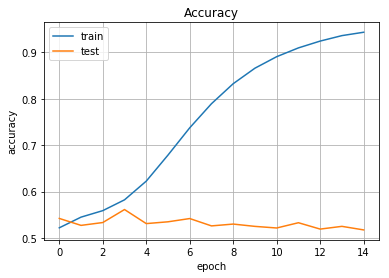

In [36]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

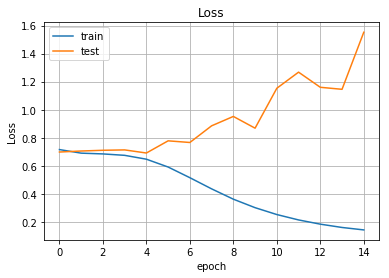

In [38]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()